# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how to easy is to port the [`pymc`](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [`bambi`](https://bambinos.github.io/bambi/main/index.html) using the formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

## Read Data

Let us load the data into a pandas dataframe.

In [2]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"

srrs2 = pd.read_csv(path, sep=",",  on_bad_lines="skip")

## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [3]:
# TODO: Organize this pre-processing steps and keep just the relevant ones.

# Filter data for state `MN`
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Compute fips
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

# Get city data
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

# Merge data
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

# Get lookup table for counties
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

# local copies of variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

srrs_mn.sort_values(by="floor", inplace=True)

# Map 0 -> Basement and 1 -> Floor
srrs_mn["floor"] = srrs_mn["floor"].map({0: "Basement", 1: "Floor"})

## Models: Conventional Approaches

### Complete Pooling

Let us start by considering the complete pooling model on which we treat all counties the same, and estimate a single radon level. That is, 

$$y_i = \alpha + \beta x_i + \epsilon_i$$

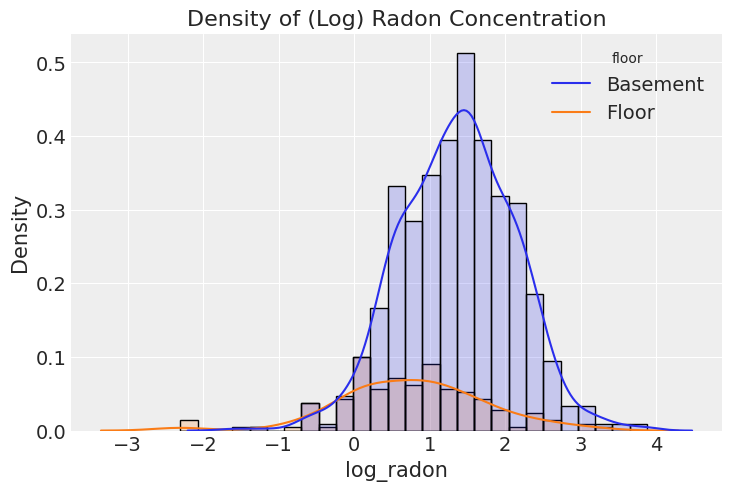

In [4]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", hue="floor", alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", hue="floor", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log) Radon Concentration", ylabel="Density");

In [5]:
pooled_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

pooled_model = bmb.Model(
    formula="log_radon ~ 0 + floor",
    data=srrs_mn,
    priors=pooled_priors,
    family="gaussian",
    link="identity",
)

pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [6]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


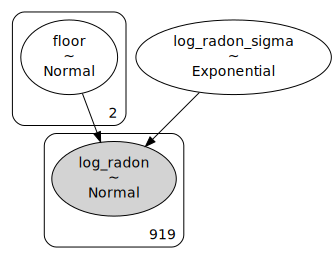

In [7]:
pm.model_to_graphviz(pooled_model.backend.model)

In [8]:
az.summary(data=pooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
floor[Basement],1.363,0.028,1.311,1.417,0.001,0.000,2293.0,1534.0,1.0
floor[Floor],0.776,0.066,0.654,0.902,0.001,0.001,2935.0,1547.0,1.0
log_radon_sigma,0.792,0.018,0.756,0.824,0.000,0.000,2732.0,1338.0,1.0


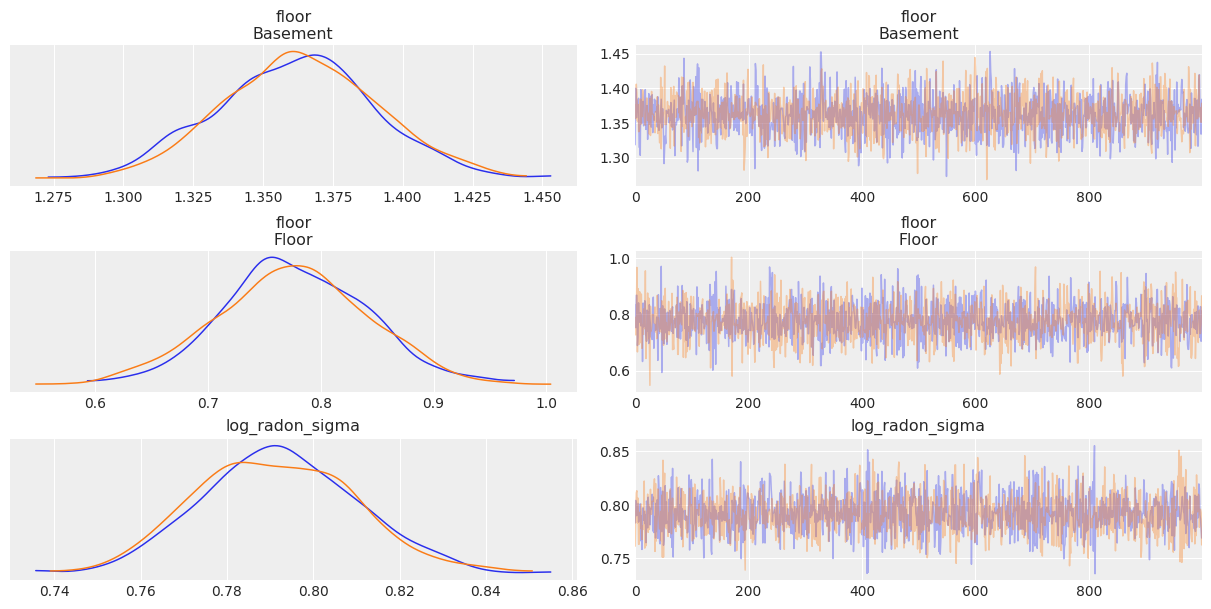

In [9]:
az.plot_trace(data=pooled_results, compact=False);

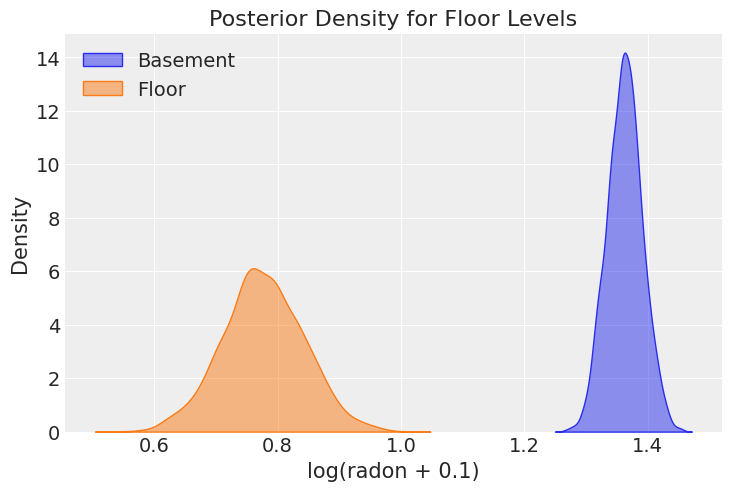

In [10]:
pooled_results_posterior_stacked = pooled_results.posterior.stack(sample=("chain", "draw"))

fig, ax = plt.subplots()
sns.kdeplot(
    x=pooled_results_posterior_stacked["floor"].sel({"floor_coord": "Basement"}),
    fill=True,
    alpha=0.5,
    label="Basement",
    ax=ax
);

sns.kdeplot(
    x=pooled_results_posterior_stacked["floor"].sel({"floor_coord": "Floor"}),
    fill=True,
    alpha=0.5,
    label="Floor",
    ax=ax
)

ax.legend(loc="upper left")
ax.set(
    title="Posterior Density for Floor Levels", 
    xlabel="log(radon + 0.1)", 
    ylabel="Density"
);

### No Pooling

Nex, we consider the model in which radon is modeled in each county independently, i.e. 

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$



In [11]:
unpooled_priors = {
    "county:floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

unpooled_model = bmb.Model("log_radon ~ 0 + county:floor", srrs_mn, priors=unpooled_priors)
unpooled_model

Formula: log_radon ~ 0 + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county:floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [12]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 46 seconds.


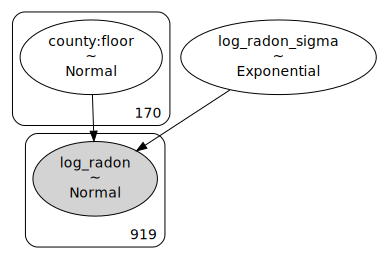

In [13]:
pm.model_to_graphviz(unpooled_model.backend.model)

In [14]:
az.summary(data=unpooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"county:floor[AITKIN, Basement]",0.661,0.430,-0.141,1.426,0.007,0.007,3622.0,1297.0,1.0
"county:floor[AITKIN, Floor]",0.808,0.732,-0.486,2.264,0.012,0.012,3671.0,1280.0,1.0
"county:floor[ANOKA, Basement]",0.952,0.102,0.754,1.145,0.002,0.001,3284.0,1297.0,1.0
"county:floor[ANOKA, Floor]",-0.129,0.403,-0.902,0.621,0.006,0.009,4939.0,1421.0,1.0
"county:floor[BECKER, Basement]",1.472,0.696,0.154,2.731,0.011,0.009,3982.0,1457.0,1.0
...,...,...,...,...,...,...,...,...,...
"county:floor[WRIGHT, Basement]",1.673,0.203,1.298,2.047,0.004,0.003,3112.0,1365.0,1.0
"county:floor[WRIGHT, Floor]",0.867,0.714,-0.482,2.194,0.012,0.012,3729.0,1002.0,1.0
"county:floor[YELLOW MEDICINE, Basement]",1.221,0.489,0.366,2.178,0.008,0.006,3594.0,1321.0,1.0
"county:floor[YELLOW MEDICINE, Floor]",-0.006,10.163,-19.375,17.930,0.167,0.271,3698.0,1217.0,1.0


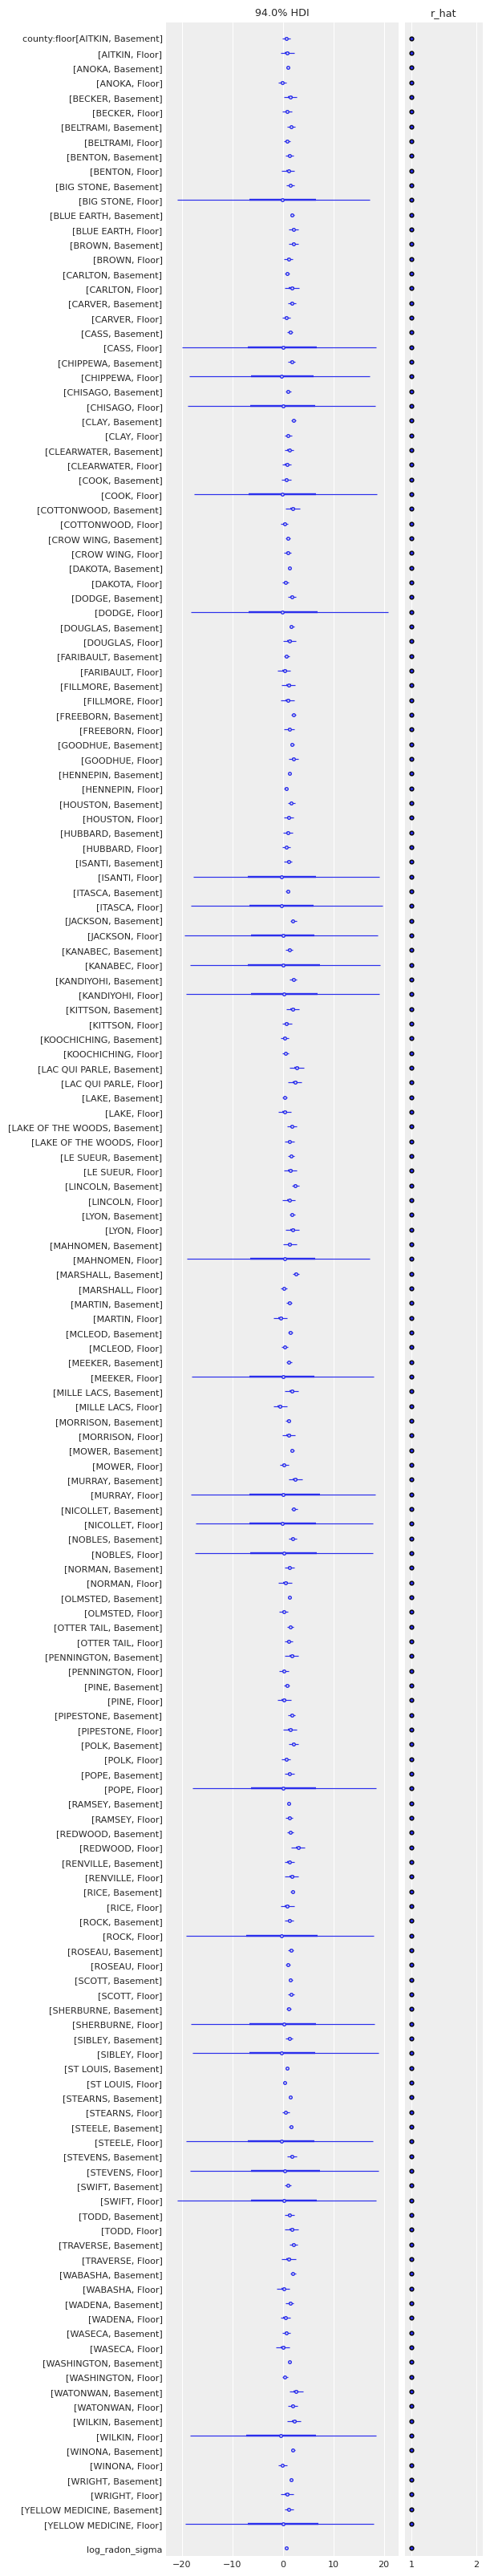

In [15]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

## Multilevel and Hierarchical Models

### Partial Pooling Model

$$y_i = \alpha_{j[i]} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [16]:
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0.0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

partial_pooling_model = bmb.Model(
    "log_radon ~ 1 + (1|county)", 
    srrs_mn, 
    priors=partial_pooling_priors
)
partial_pooling_model

Formula: log_radon ~ 1 + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [17]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county_offset, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


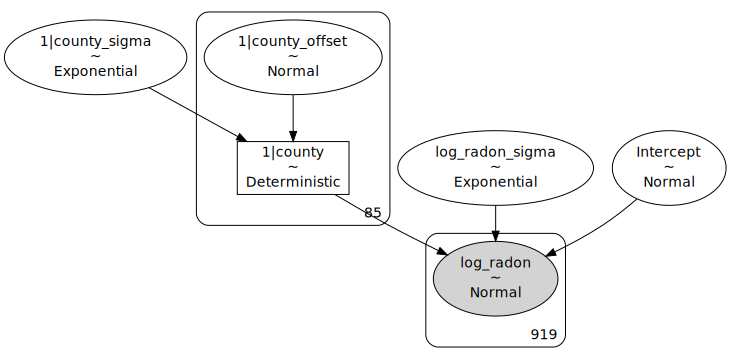

In [18]:
pm.model_to_graphviz(partial_pooling_model.backend.model)

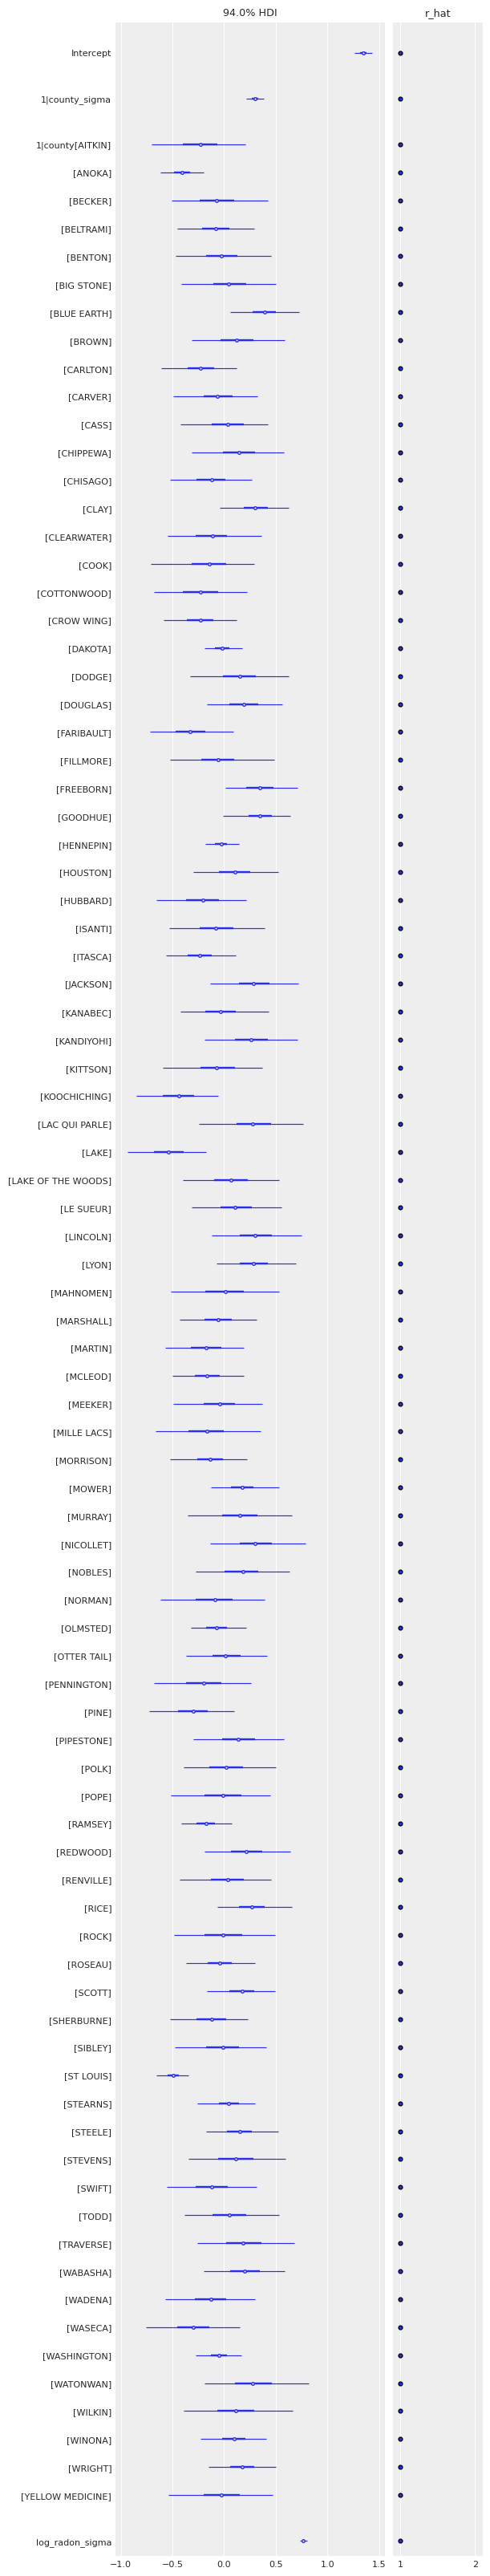

In [19]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept Model

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [20]:
varying_intercept_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=10),
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    "log_radon ~ 0 + floor + (1|county)",
    srrs_mn,
    priors=varying_intercept_priors,
 )

In [21]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county_offset, 1|county_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


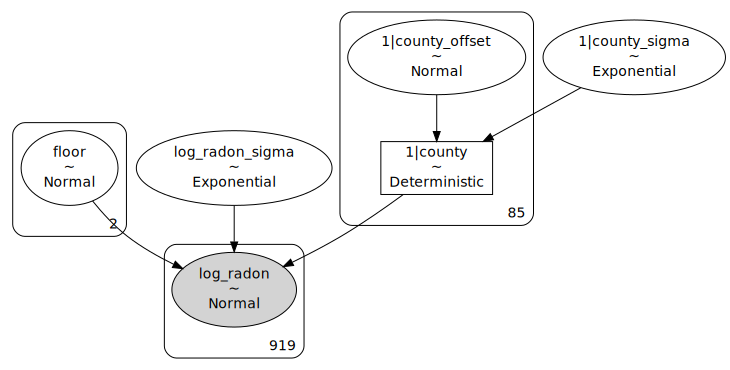

In [22]:
pm.model_to_graphviz(varying_intercept_model.backend.model)

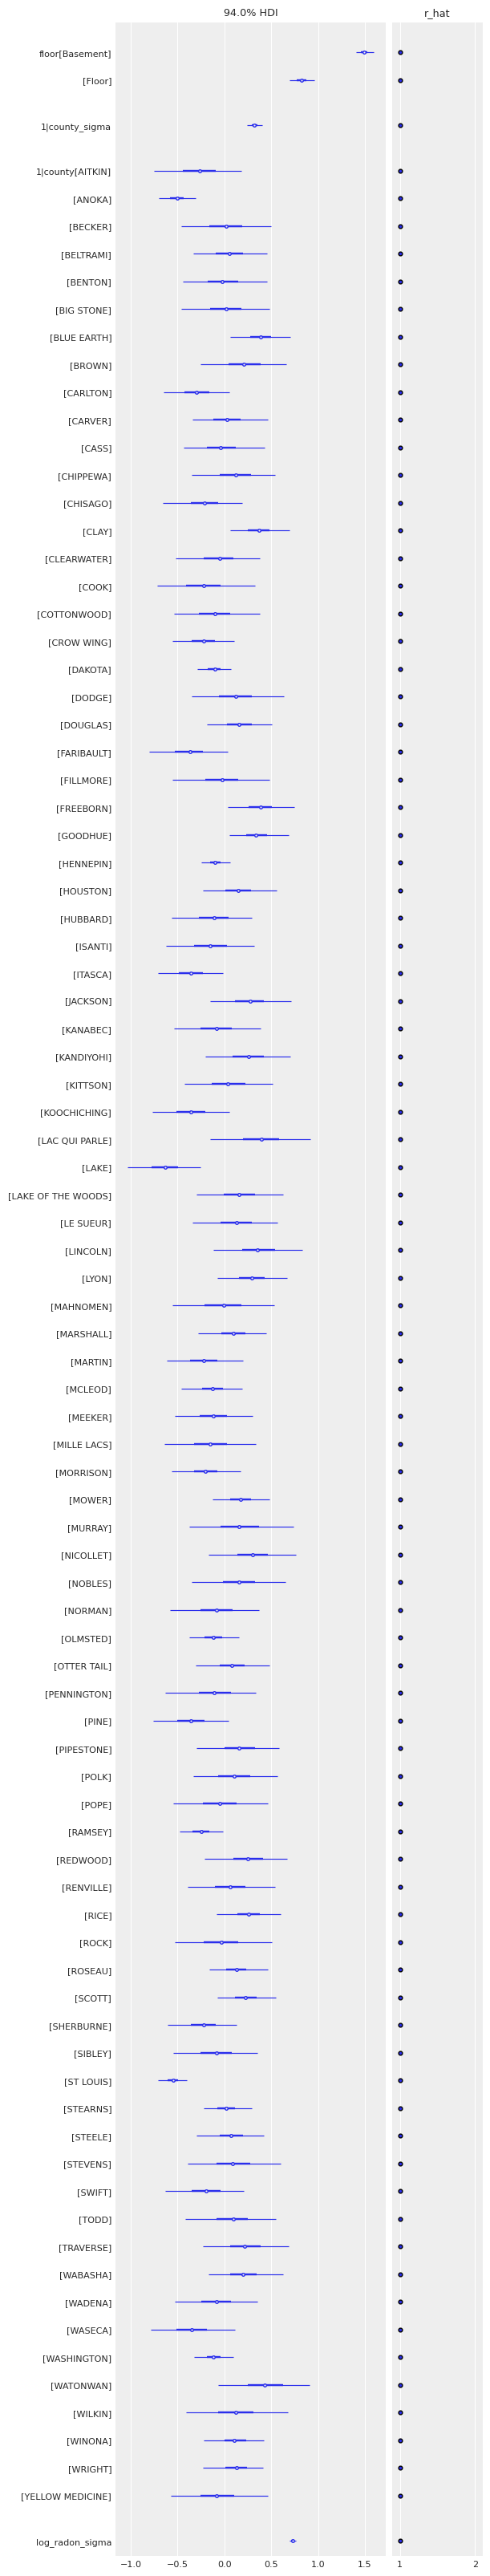

In [23]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

In [24]:
varying_intercept_slope_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ (floor|county)",
    data=srrs_mn,
    priors=varying_intercept_slope_priors,
 )

In [25]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county_offset, floor|county_sigma, 1|county_offset, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


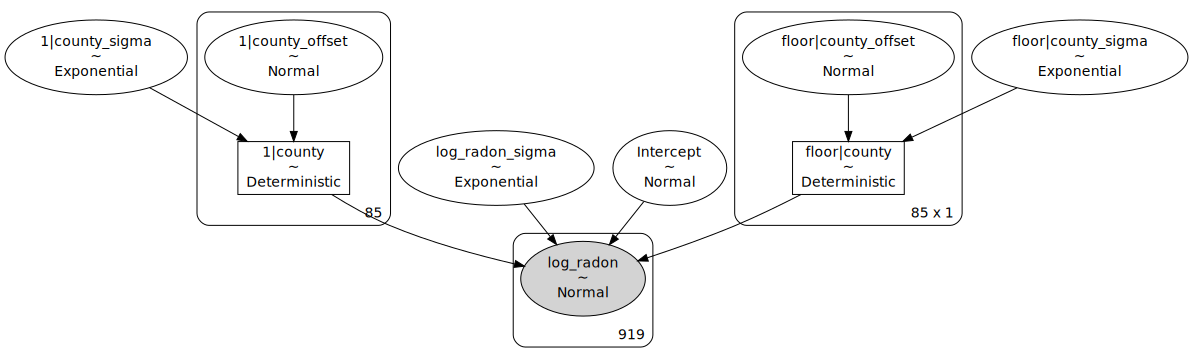

In [26]:
pm.model_to_graphviz(varying_intercept_slope_model.backend.model)

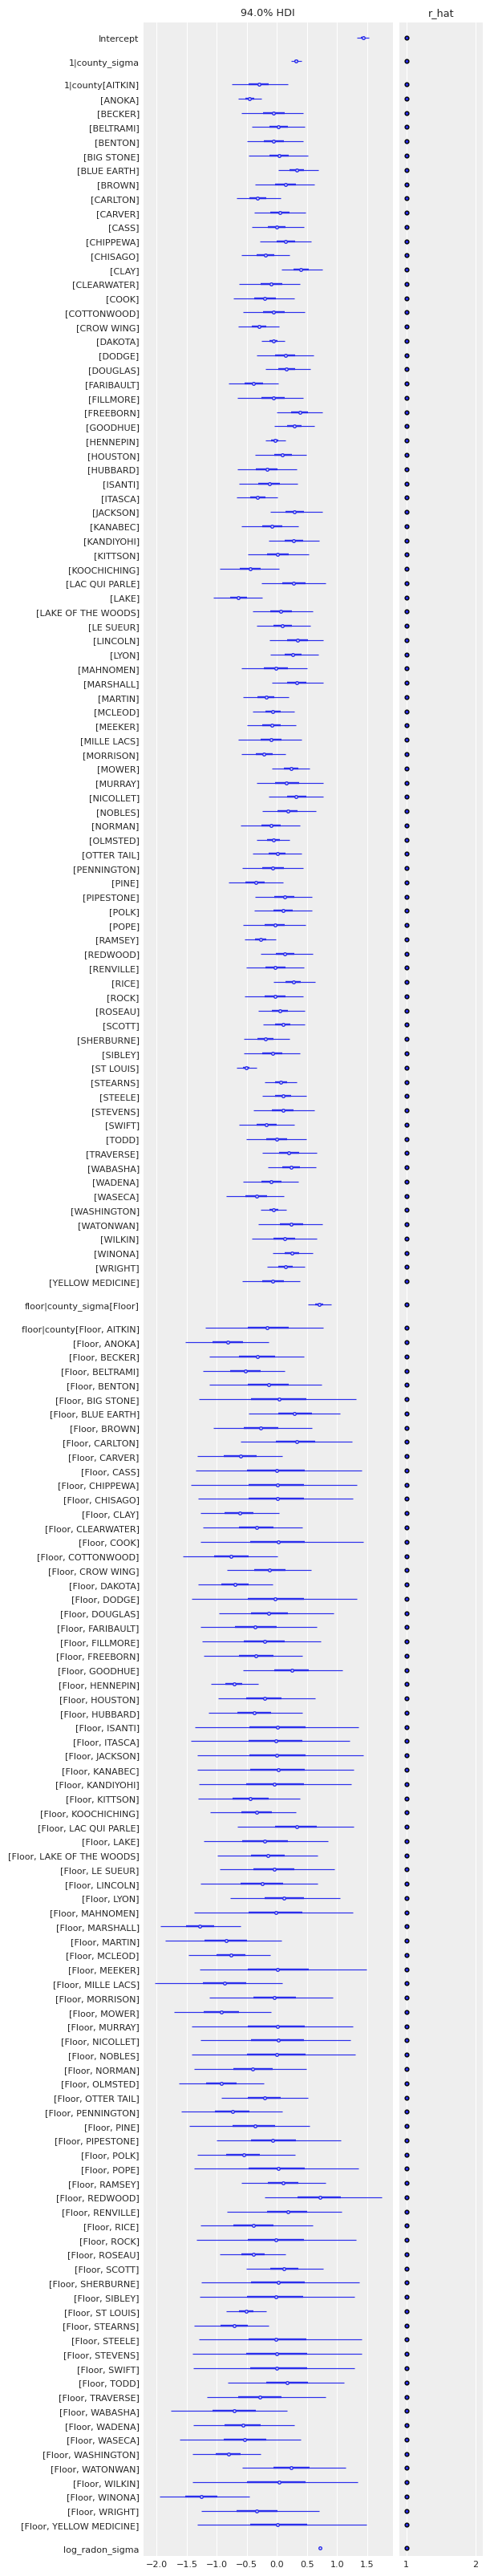

In [27]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

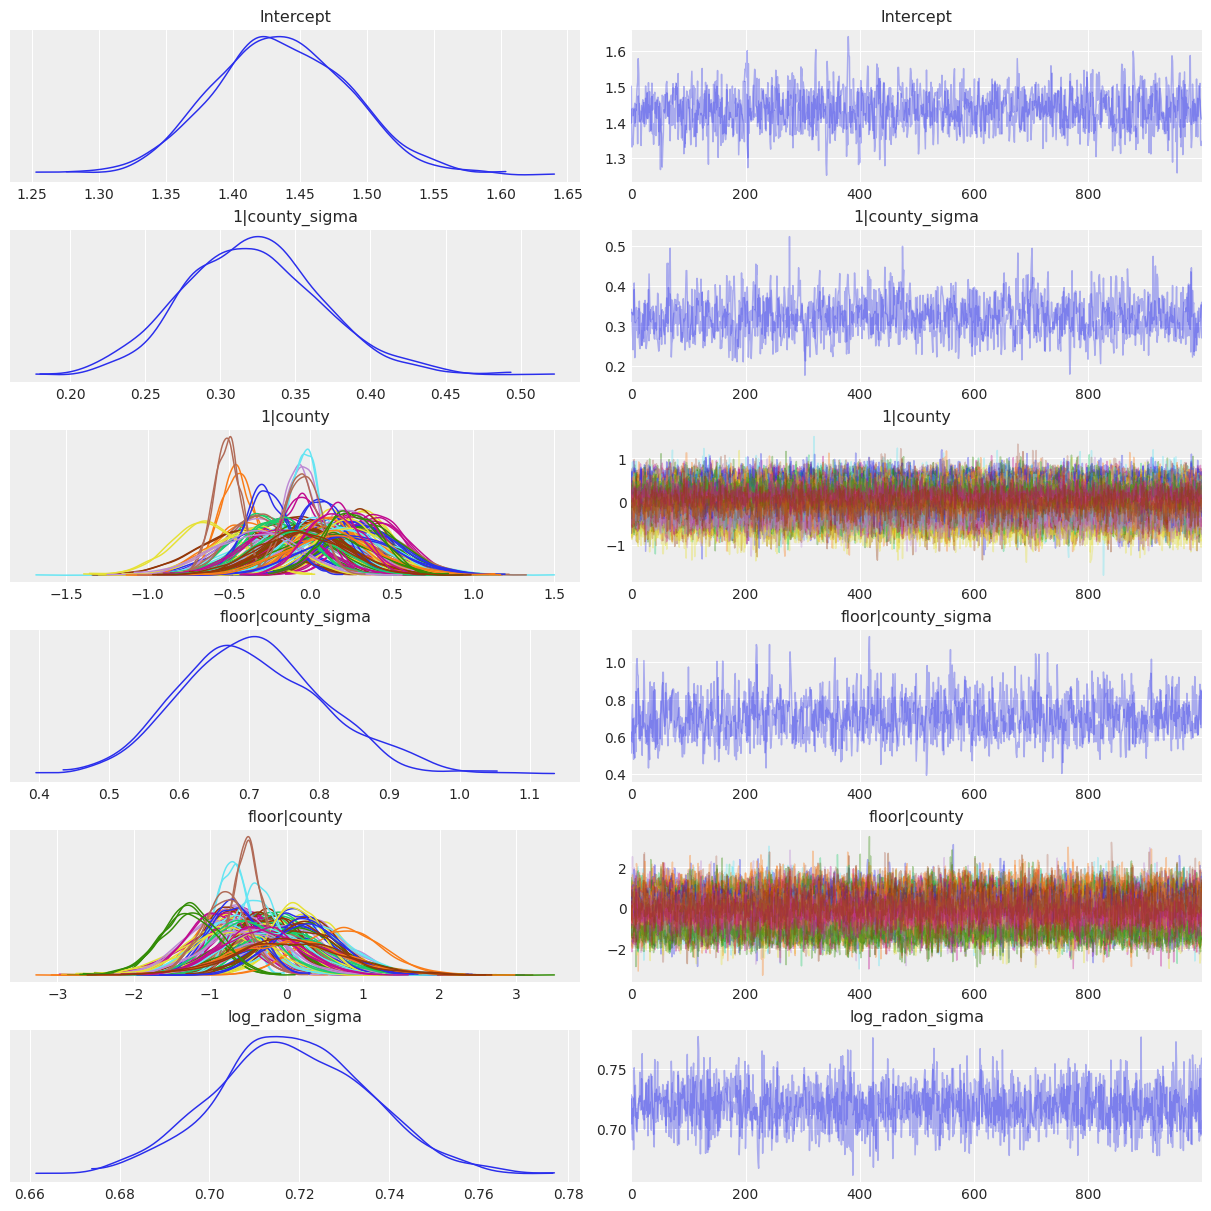

In [28]:
az.plot_trace(varying_intercept_slope_results, compact=True, chain_prop={"ls": "-"});

**NOTE:** We can do the following and it "works". But I wouldn't keep this in this notebook because it is still quite experimental and buggy. I'd prefer to fix the implementation and we can update the notebook after that.

In [32]:
priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

model = bmb.Model(
    formula="log_radon ~ (0 + floor|county)",
    data=srrs_mn,
    priors=priors,
    priors_cor={"county": 2}
 )

model.build()

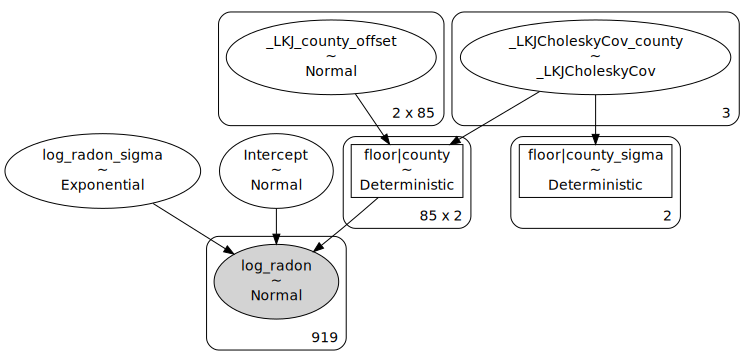

In [33]:
model.graph()

In [34]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, _LKJ_county_offset, _LKJCholeskyCov_county, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.


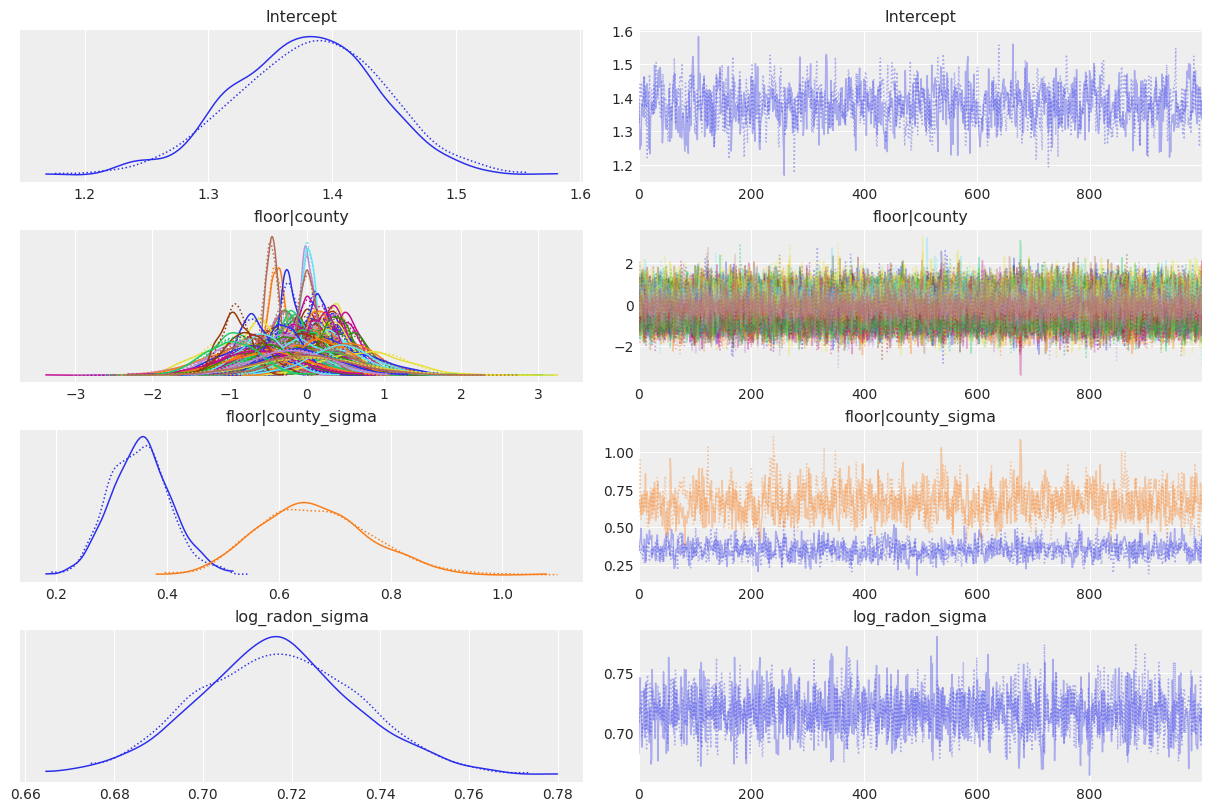

In [35]:
az.plot_trace(idata);